In [1]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from typing import Any

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision.transforms import ToPILImage

from anomalib import TaskType
from anomalib.data import MVTec
from anomalib.engine import Engine
from anomalib.models import Patchcore, EfficientAd

import torch
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance
from qdrant_client.http import models as qdrant_models
import torchvision.transforms as transforms
import os
import uuid

In [ ]:
datamodule = MVTec()
datamodule.prepare_data()  
datamodule.setup()  #Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())

mvtec: 5.26GB [04:27, 19.7MB/s]                            


dict_keys(['image_path', 'label', 'image', 'mask'])


In [14]:
print(data["image"].shape, data["mask"].shape)

torch.Size([32, 3, 900, 900]) torch.Size([32, 900, 900])


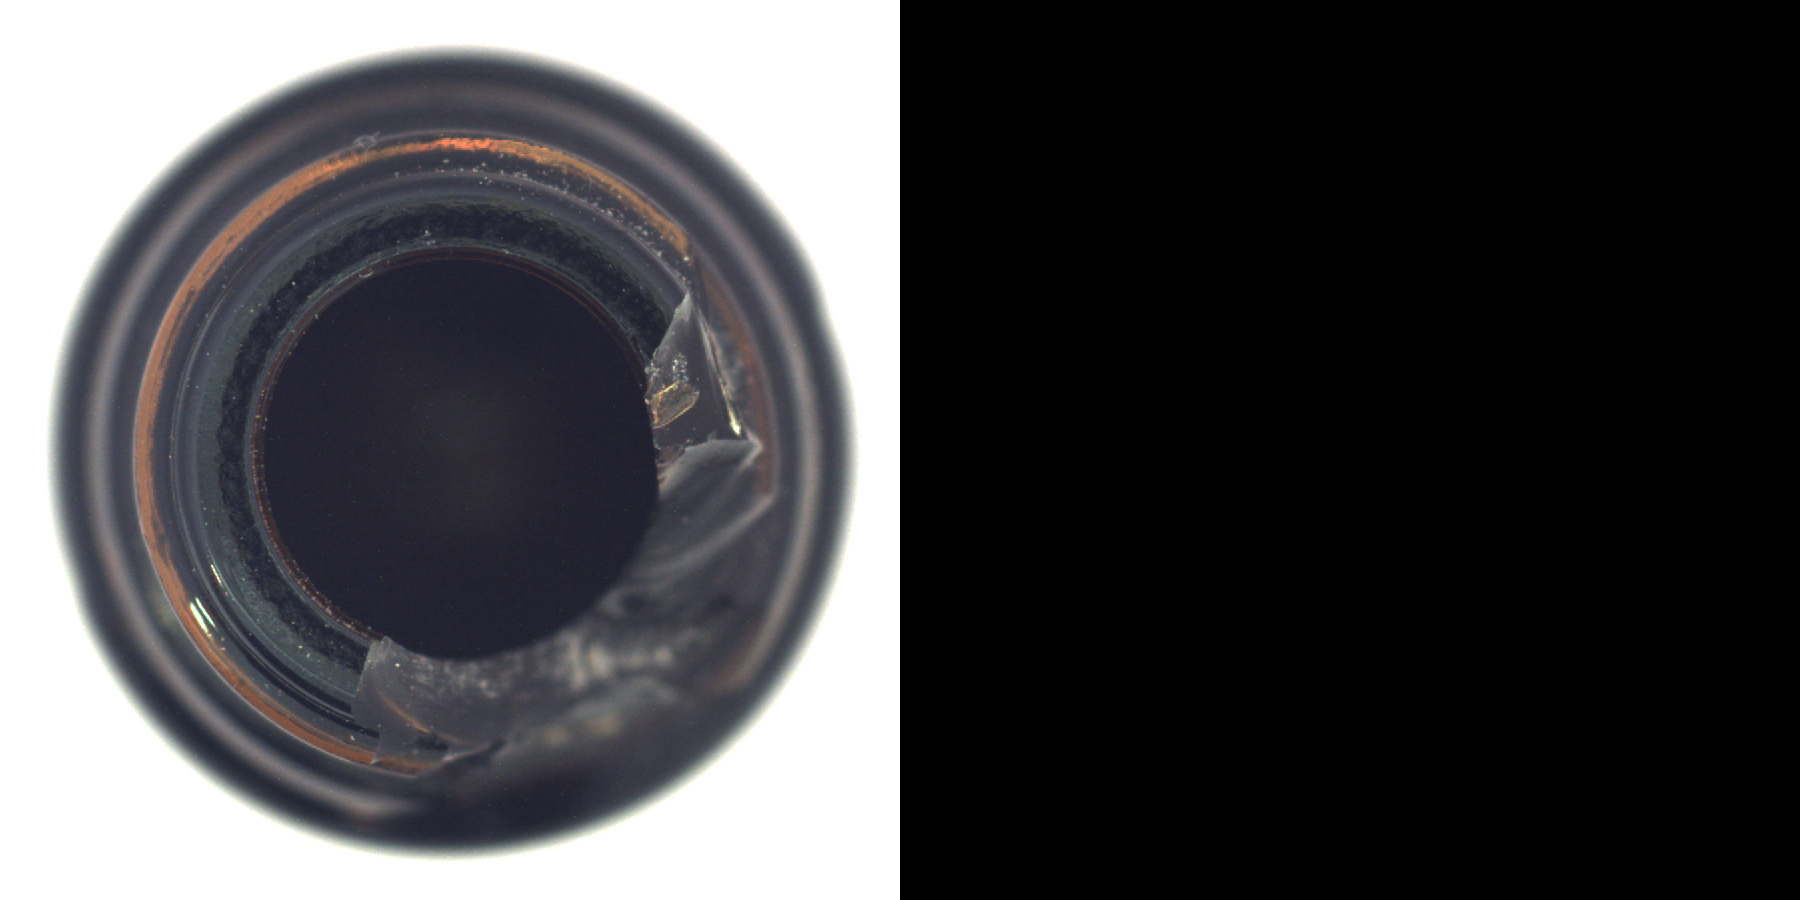

In [15]:
def show_image_and_mask(sample: dict[str, Any], index: int) -> Image:
    """Show an image with a mask.

    Args:
        sample (dict[str, Any]): Sample from the dataset.
        index (int): Index of the sample.

    Returns:
        Image: Output image with a mask.
    """
    # Load the image from the path
    image = Image.open(sample["image_path"][index])

    # Load the mask and convert it to RGB
    mask = ToPILImage()(sample["mask"][index]).convert("RGB")

    # Resize mask to match image size, if they differ
    if image.size != mask.size:
        mask = mask.resize(image.size)

    return Image.fromarray(np.hstack((np.array(image), np.array(mask))))


# Visualize an image with a mask
show_image_and_mask(data, index=0)

# Patchcore

Training Paradigm:
1. Patch-Level Feature Extraction: PatchCore divides an input image into small patches. Each patch is analyzed using a pre-trained CNN backbone like wide_resnet50_2. It then extracts feature vectors for each patch. The CNN generates high-dimensional embeddings that are then sampled using coreset-sampling.
2. Core-Set Sampling: PatchCore employs core-set sampling to retain only a representative subset of feature vectors, known as memory banks.


Testing Paradigm:
1. The test image is similarly divided into patches, and features are extracted using the same CNN backbone.
2. Nearest Neighbor Search: For each test patch, PatchCore computes similarity to the nearest patches in the memory bank using Euclidean or Cosine distance. The anomaly score for each patch is then based on the distance to its nearest neighbor. A larger distance suggests a potential anomaly.
3. Patch-level scores are combined to yield an overall anomaly score for the image.
4. Anomaly scores are mapped back to patches to create a heatmap that indicates anomaly likelihood, which is then upsampled to show pixel-level anomaly scores.

In [ ]:
#Function to train PatchCore on the specified category and test
def evaluate_patchcore_on_categories(c):
    pixel_aurocs = {}
    image_aurocs = {}

    model = Patchcore(pre_trained=True)
    mvtec_datamodule = MVTec(
        category= c,
        image_size= [224,224]
    )
    mvtec_datamodule.prepare_data()
    mvtec_datamodule.setup()

    engine = Engine(task=TaskType.SEGMENTATION)

    engine.fit(model=model, datamodule=mvtec_datamodule)

    # Load the best checkpoint for evaluation
    test_results = engine.test(
        model=model,
        datamodule=mvtec_datamodule,
        ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
    )

    # Store AUROC scores
    if len(test_results) > 0:
      pixel_aurocs[c] = test_results[0].get('pixel_AUROC', None)
      image_aurocs[c] = test_results[0].get('image_AUROC', None)

    print(f"Category: {c}")
    print(test_results)
    print("====================================================================================")


    return pixel_aurocs, image_aurocs

In [ ]:
#Training and testing on the tile category
pixel_aurocs = {}
image_aurocs = {}

pixel_auroc, image_auroc = evaluate_patchcore_on_categories('tile')
pixel_aurocs['tile'] = pixel_auroc
image_aurocs['tile'] = image_auroc

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | PatchcoreModel           | 24.9 M | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0 

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/14375 [00:00<?, ?it/s]

Selecting Coreset Indices.:   0%|          | 15/14375 [00:00<01:36, 149.38it/s]

Selecting Coreset Indices.:   0%|          | 30/14375 [00:00<01:58, 120.59it/s]

Selecting Coreset Indices.:   0%|          | 43/14375 [00:00<02:03, 116.33it/s]

Selecting Coreset Indices.:   0%|          | 58/14375 [00:00<01:52, 127.60it/s]

Selecting Coreset Indices.:   1%|          | 72/14375 [00:00<01:48, 131.35it/s]

Selecting Coreset Indices.:   1%|          | 91/14375 [00:00<01:35, 150.18it/s]

Selecting Coreset Indices.:   1%|          | 107/14375 [00:00<01:45, 135.46it/s]

Selecting Coreset Indices.:   1%|          | 121/14375 [00:00<01:49, 130.72it/s]

Selecting Coreset Indices.:   1%|          | 135/14375 [00:01<01:55, 122.98it/s]

Selecting Coreset Indices.:   1%|          | 148/14375 [00:01<02:04, 113.91it/s]

Selecting Coreset Indices.:   1%|          | 160/14375 [00:01<02:21, 100.33it/s]

Selecting Coreset Indices.:   1

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9927849769592285     │
│       image_F1Score       │    0.9818181991577148     │
│        pixel_AUROC        │    0.9433835744857788     │
│       pixel_F1Score       │    0.6131219267845154     │
└───────────────────────────┴───────────────────────────┘

Category: tile
[{'pixel_AUROC': 0.9433835744857788, 'pixel_F1Score': 0.6131219267845154, 'image_AUROC': 0.9927849769592285, 'image_F1Score': 0.9818181991577148}]


In [ ]:
#Training and testing on the grid category
pixel_auroc, image_auroc = evaluate_patchcore_on_categories('grid')
pixel_aurocs['grid'] = pixel_auroc
image_aurocs['grid'] = image_auroc

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | PatchcoreModel           | 24.9 M | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0 

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/16500 [00:00<?, ?it/s]

Selecting Coreset Indices.:   0%|          | 16/16500 [00:00<01:44, 157.77it/s]

Selecting Coreset Indices.:   0%|          | 32/16500 [00:00<01:51, 147.27it/s]

Selecting Coreset Indices.:   0%|          | 49/16500 [00:00<01:45, 156.05it/s]

Selecting Coreset Indices.:   0%|          | 65/16500 [00:00<01:58, 138.19it/s]

Selecting Coreset Indices.:   0%|          | 80/16500 [00:00<02:25, 112.52it/s]

Selecting Coreset Indices.:   1%|          | 93/16500 [00:00<02:30, 109.01it/s]

Selecting Coreset Indices.:   1%|          | 105/16500 [00:00<02:43, 100.31it/s]

Selecting Coreset Indices.:   1%|          | 117/16500 [00:01<02:37, 104.15it/s]

Selecting Coreset Indices.:   1%|          | 132/16500 [00:01<02:21, 115.35it/s]

Selecting Coreset Indices.:   1%|          | 144/16500 [00:01<02:23, 114.14it/s]

Selecting Coreset Indices.:   1%|          | 157/16500 [00:01<02:18, 118.18it/s]

Selecting Coreset Indices.:   1

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9807853102684021     │
│       image_F1Score       │    0.9642857313156128     │
│        pixel_AUROC        │    0.9731547832489014     │
│       pixel_F1Score       │    0.34392067790031433    │
└───────────────────────────┴───────────────────────────┘

Category: grid
[{'pixel_AUROC': 0.9731547832489014, 'pixel_F1Score': 0.34392067790031433, 'image_AUROC': 0.9807853102684021, 'image_F1Score': 0.9642857313156128}]


In [ ]:
#Training and testing on the leather category
pixel_auroc, image_auroc = evaluate_patchcore_on_categories('leather')
pixel_aurocs['leather'] = pixel_auroc
image_aurocs['leather'] = image_auroc

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | PatchcoreModel           | 24.9 M | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0 

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/15312 [00:00<?, ?it/s]

Selecting Coreset Indices.:   0%|          | 5/15312 [00:00<05:27, 46.72it/s]

Selecting Coreset Indices.:   0%|          | 11/15312 [00:00<04:48, 53.12it/s]

Selecting Coreset Indices.:   0%|          | 18/15312 [00:00<04:21, 58.50it/s]

Selecting Coreset Indices.:   0%|          | 27/15312 [00:00<03:42, 68.59it/s]

Selecting Coreset Indices.:   0%|          | 38/15312 [00:00<03:12, 79.39it/s]

Selecting Coreset Indices.:   0%|          | 48/15312 [00:00<02:59, 84.89it/s]

Selecting Coreset Indices.:   0%|          | 57/15312 [00:00<03:02, 83.67it/s]

Selecting Coreset Indices.:   0%|          | 66/15312 [00:00<03:09, 80.28it/s]

Selecting Coreset Indices.:   0%|          | 76/15312 [00:00<02:57, 85.70it/s]

Selecting Coreset Indices.:   1%|          | 86/15312 [00:01<02:50, 89.28it/s]

Selecting Coreset Indices.:   1%|          | 97/15312 [00:01<02:41, 94.27it/s]

Selecting Coreset Indices.:   1%|          | 110

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            1.0            │
│       image_F1Score       │     0.994535505771637     │
│        pixel_AUROC        │    0.9884014129638672     │
│       pixel_F1Score       │    0.4125872254371643     │
└───────────────────────────┴───────────────────────────┘

Category: leather
[{'pixel_AUROC': 0.9884014129638672, 'pixel_F1Score': 0.4125872254371643, 'image_AUROC': 1.0, 'image_F1Score': 0.994535505771637}]


In [ ]:
# Calculate average AUROC across categories
combined_pixel_auroc = sum([list(scores.values())[0] for scores in pixel_aurocs.values()]) / len(pixel_aurocs)
combined_image_auroc = sum([list(scores.values())[0] for scores in image_aurocs.values()]) / len(image_aurocs)

print(f"Average Pixel AUROC: {combined_pixel_auroc:.4f}")
print(f"Average Image AUROC: {combined_image_auroc:.4f}")

Average Pixel AUROC: 0.9679
Average Image AUROC: 0.9899


In [ ]:
def plot_anomaly_heatmap(original_img, anomaly_map, title):
    # Normalize the anomaly map to [0, 1]
    anomaly_map = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min())
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_img)
    ax[0].set_title("Original Image")

    # Display the original image with an overlay of the anomaly map
    heatmap = ax[1].imshow(original_img)
    ax[1].imshow(anomaly_map, cmap='jet', alpha=0.1)
    ax[1].set_title(f"{title} Heatmap Overlay")
    
    plt.colorbar(ax[1].images[-1], ax=ax[1], fraction=0.046, pad=0.04)
    plt.show()

PatchCore model loaded successfully from checkpoint.


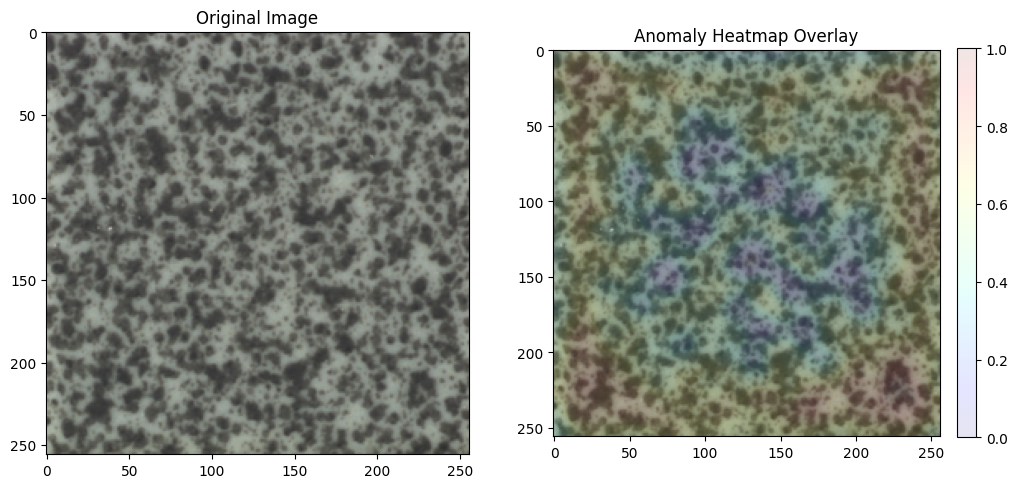

In [ ]:
model = Patchcore(pre_trained=False)
model.eval()

# Load the checkpoint
checkpoint_path = "/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/results/Patchcore_tile/model.ckpt"
checkpoint = torch.load(checkpoint_path,map_location="cpu")
model.load_state_dict(checkpoint['state_dict'])
print("PatchCore model loaded successfully from checkpoint.")

original_img = "/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/train/good/205.png" 
image = Image.open(original_img).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

image = transform(image).unsqueeze(0)

with torch.no_grad():
  features = model(image)
    

feature_vector = features['anomaly_map'].squeeze().numpy()

mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
image_denorm = image * std + mean  # Undo normalization
image_denorm = image_denorm.squeeze(0).permute(1, 2, 0).numpy()  
image_denorm = np.clip(image_denorm, 0, 1)  # Clip values to [0, 1] range


anomaly_map = feature_vector  
plot_anomaly_heatmap(image_denorm, anomaly_map "Anomaly")

# EfficientAD

Architecture:

1. Teacher Model: A larger backbone (like EfficientNet) that is pretrained on a large dataset. It captures comprehensive features and representations of the data, serving as a reference for the student model.
2. Student Model: A smaller network that learns to replicate the teacher's output using knowledge distillation techniques. The student model is designed to be computationally efficient.


Training Paradigm: 

1. Teacher Model Training: The teacher model is pretrained on a dataset containing normal samples which outputs a feature representation for each image, to be used as the target for the student model.
2. Student Model Training: The student model is then trained using the outputs of the teacher model. The student model processes the same input images and tries to minimize the difference between its own output and the teacher's output. The student learns from the teacher's soft labels using kwonledge distillation techniques.
3. Anomaly Score Calculation: Anomaly scores are derived from the differences in outputs between the student model and the teacher model. If the student's reconstruction or classification significantly deviates from the teacher's, it indicates potential anomalies.


Testing Paradigm:

1. Feature Extraction: During testing, the test images are passed through both the teacher and student models to obtain their respective feature representations.
2. Anomaly Scoring: The anomaly score for each test image is calculated based on the differences in outputs between the student and teacher models. A higher score indicates a higher likelihood of the image being anomalous.
3. Anomaly Localization: EfficientAD can also localize where anomalies occur in an image.

In [ ]:
#Function to train EAD and test on the given category
def evaluate_EAD(c):
    pixel_aurocs = {}
    image_aurocs = {}

    model = EfficientAd(padding=True)
    mvtec_datamodule = MVTec(
        train_batch_size=1,
        eval_batch_size=1,
        category=c,
        image_size= [256,256]
    )
    mvtec_datamodule.prepare_data()
    mvtec_datamodule.setup()

    engine = Engine(task=TaskType.SEGMENTATION, max_epochs=20)

    engine.fit(model=model, datamodule=mvtec_datamodule)

    # Load the best checkpoint for evaluation
    test_results = engine.test(
        model=model,
        datamodule=mvtec_datamodule,
        ckpt_path=engine.trainer.checkpoint_callback.best_model_path,
    )

    # Store AUROC scores
    if len(test_results) > 0:
      pixel_aurocs[c] = test_results[0].get('pixel_AUROC', None)
      image_aurocs[c] = test_results[0].get('image_AUROC', None)

    print(f"Category: {c}")
    print(test_results)
    print("====================================================================================")


    return pixel_aurocs, image_aurocs

In [18]:
pixel_aurocs = {}
image_aurocs = {}

In [ ]:
#Training and testing on the tile category
pixel_auroc, image_auroc = evaluate_EAD('tile')
pixel_aurocs['tile'] = pixel_auroc
image_aurocs['tile'] = image_auroc

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | EfficientAdModel         | 8.1 M  | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0 

Training: |          | 0/? [00:00<?, ?it/s]

Calculate teacher channel mean & std: 100%|██████████| 230/230 [00:02<00:00, 105.71it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 82.83it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 82.10it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 81.60it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 84.71it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 82.95it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 83.24it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 82.96it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 82.70it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 79.71it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 82.09it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 80.03it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 81.92it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 79.11it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 82.38it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 81.82it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 81.12it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 80.43it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 81.77it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 80.66it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 117/117 [00:01<00:00, 79.34it/s] 
INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: Restoring states from the checkpoint path at /content/results/EfficientAd/MVTec/tile/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/results/EfficientAd/MVTec/tile/v0/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/results/EfficientAd/MVTec/tile/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/EfficientAd/MVTec/tile/v0/weights/lightning/model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │     0.998917818069458     │
│       image_F1Score       │    0.9822485446929932     │
│        pixel_AUROC        │    0.8790363073348999     │
│       pixel_F1Score       │    0.6730937361717224     │
└───────────────────────────┴───────────────────────────┘

Category: tile
[{'pixel_AUROC': 0.8790363073348999, 'pixel_F1Score': 0.6730937361717224, 'image_AUROC': 0.998917818069458, 'image_F1Score': 0.9822485446929932}]


In [ ]:
#Training and testing on the leather category
pixel_auroc, image_auroc = evaluate_EAD('leather')
pixel_aurocs['leather'] = pixel_auroc
image_aurocs['leather'] = image_auroc

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | EfficientAdModel         | 8.1 M  | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0 

Training: |          | 0/? [00:00<?, ?it/s]

Calculate teacher channel mean & std: 100%|██████████| 245/245 [00:02<00:00, 87.80it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 65.06it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 68.48it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 68.21it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 66.66it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 66.82it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 68.83it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 67.71it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 69.41it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 67.58it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 66.26it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 65.86it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 65.14it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 66.80it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 68.72it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 69.76it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 66.38it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 71.07it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 66.73it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 67.46it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 124/124 [00:01<00:00, 68.80it/s]
INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: Restoring states from the checkpoint path at /content/results/EfficientAd/MVTec/leather/v1/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/results/EfficientAd/MVTec/leather/v1/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/results/EfficientAd/MVTec/leather/v1/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/EfficientAd/MVTec/leather/v1/weights/lightning/model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9650136232376099     │
│       image_F1Score       │    0.9438202381134033     │
│        pixel_AUROC        │    0.9560245275497437     │
│       pixel_F1Score       │    0.4662857949733734     │
└───────────────────────────┴───────────────────────────┘

Category: leather
[{'pixel_AUROC': 0.9560245275497437, 'pixel_F1Score': 0.4662857949733734, 'image_AUROC': 0.9650136232376099, 'image_F1Score': 0.9438202381134033}]


In [ ]:
#Training and testing on the grid category
pixel_auroc, image_auroc = evaluate_EAD('grid')
pixel_aurocs['grid'] = pixel_auroc
image_aurocs['grid'] = image_auroc

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | EfficientAdModel         | 8.1 M  | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0 

Training: |          | 0/? [00:00<?, ?it/s]

Calculate teacher channel mean & std: 100%|██████████| 264/264 [00:02<00:00, 126.83it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 67.49it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 72.28it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 74.11it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 73.33it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 69.64it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 71.81it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 71.27it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 71.77it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 71.50it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 72.58it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 73.05it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 70.45it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 74.57it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 73.47it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 70.81it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 71.81it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 70.97it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 72.75it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 71.53it/s] 


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 78/78 [00:01<00:00, 71.74it/s] 
INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: Restoring states from the checkpoint path at /content/results/EfficientAd/MVTec/grid/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/results/EfficientAd/MVTec/grid/v0/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/results/EfficientAd/MVTec/grid/v0/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/results/EfficientAd/MVTec/grid/v0/weights/lightning/model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9832916259765625     │
│       image_F1Score       │    0.9642857313156128     │
│        pixel_AUROC        │    0.9099588394165039     │
│       pixel_F1Score       │    0.30288422107696533    │
└───────────────────────────┴───────────────────────────┘

Category: grid
[{'pixel_AUROC': 0.9099588394165039, 'pixel_F1Score': 0.30288422107696533, 'image_AUROC': 0.9832916259765625, 'image_F1Score': 0.9642857313156128}]


In [22]:
# Calculate average AUROC across categories
print(pixel_aurocs)
print(image_aurocs)
combined_pixel_auroc = sum([list(scores.values())[0] for scores in pixel_aurocs.values()]) / len(pixel_aurocs)
combined_image_auroc = sum([list(scores.values())[0] for scores in image_aurocs.values()]) / len(image_aurocs)

print(f"Average Pixel AUROC: {combined_pixel_auroc:.4f}")
print(f"Average Image AUROC: {combined_image_auroc:.4f}")

{'tile': {'tile': 0.8790363073348999}, 'leather': {'leather': 0.9560245275497437}, 'grid': {'grid': 0.9099588394165039}}
{'tile': {'tile': 0.998917818069458}, 'leather': {'leather': 0.9650136232376099}, 'grid': {'grid': 0.9832916259765625}}
Average Pixel AUROC: 0.9150
Average Image AUROC: 0.9824


EAD model loaded successfully from checkpoint.


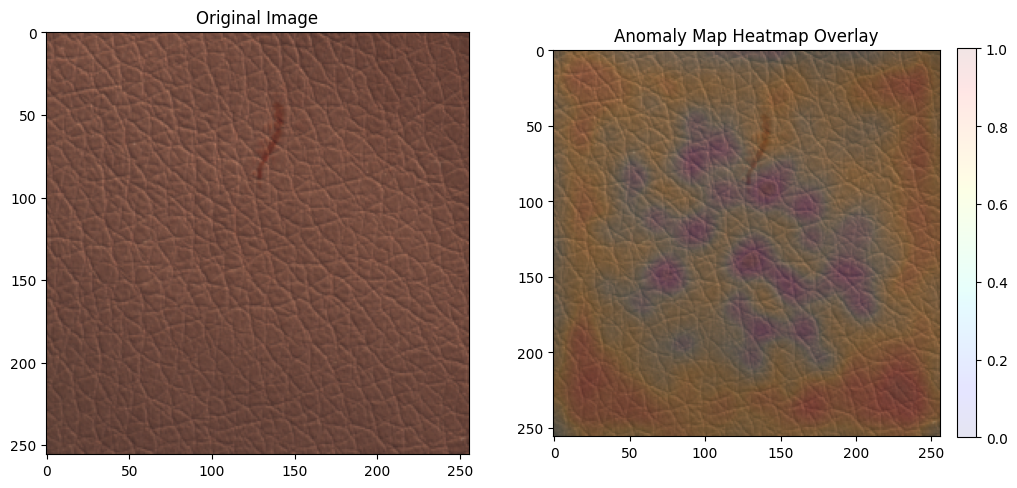

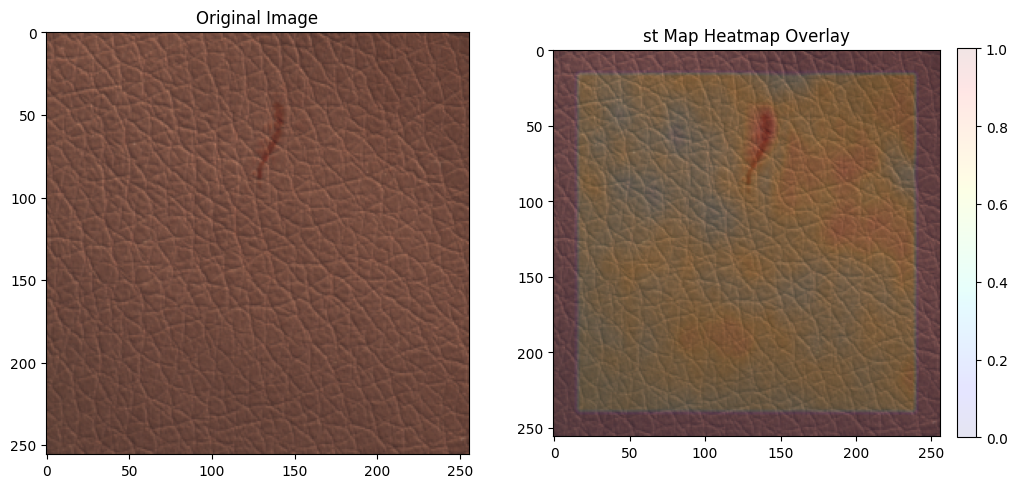

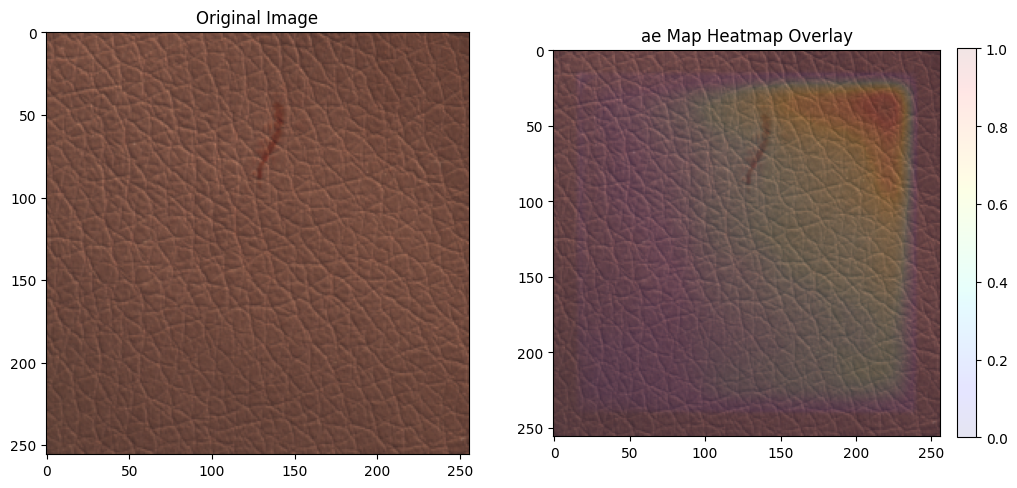

In [ ]:
model = EfficientAd()
model.eval()

# Load the checkpoint
checkpoint_path = "/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/results/EfficientAd/MVTec/leather/latest/model_EAD_leather.ckpt"
checkpoint = torch.load(checkpoint_path,map_location="cpu")
model.load_state_dict(checkpoint['state_dict'])
print("EAD model loaded successfully from checkpoint.")

original_img = "/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/leather/test/color/003.png" 
image = Image.open(original_img).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

image = transform(image).unsqueeze(0)

with torch.no_grad():
  features = model(image)


anomaly_map = features['anomaly_map'].squeeze().numpy()
st_map = features['map_st'].squeeze().numpy()
ae_map = features['map_ae'].squeeze().numpy()

mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
image_denorm = image * std + mean  # Undo normalization
image_denorm = image_denorm.squeeze(0).permute(1, 2, 0).numpy()  # Shape: (256, 256, 3)
image_denorm = np.clip(image_denorm, 0, 1)  # Clip values to [0, 1] range


anomaly_map = feature_vector  
plot_anomaly_heatmap(image_denorm, anomaly_map, "Anomaly Map")
plot_anomaly_heatmap(image_denorm, st_map, "st Map")
plot_anomaly_heatmap(image_denorm, ae_map, "ae Map")

# Similarity search


Qdrant computes the similarity between the query vector and the vectors in the collection using a defined distance metric, cosine in most cases. The most common method used is the Nearest Neighbor Search, where Qdrant retrieves the nearest vectors to the query vector based on distance calculations.

In [ ]:
#Establishing connection to the client
client = QdrantClient(url="http://localhost:6333")

#Defining collection name, size of each vector to be stored and distance calculation metric
Collection_name = 'similarity_search'
vector_size = 65536
distance = qdrant_models.Distance.COSINE 

In [ ]:
#Defining the vector configurations
vectors_config = qdrant_models.VectorParams(
    size=vector_size,
    distance=distance
)

In [ ]:
#Creating the client on the localhost
client.recreate_collection(
        collection_name=Collection_name,
        vectors_config=vectors_config  
    )

True

In [ ]:
#Using pretrained model weights
model = Patchcore(pre_trained=False)
model.eval()

# Load the checkpoint
checkpoint_path = "/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/results/Patchcore_tile/model.ckpt"
checkpoint = torch.load(checkpoint_path, map_location="cpu")
model.load_state_dict(checkpoint['state_dict'])

print("PatchCore model loaded successfully from checkpoint.")

PatchCore model loaded successfully from checkpoint.


In [ ]:
#Definig image transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

In [ ]:
#Function to extract features from an image using the pretrained model
def extract_features(image):
    image = transform(image).unsqueeze(0) 

    with torch.no_grad():
        features = model(image)
    
    feature_vector = features['anomaly_map'].squeeze().numpy()
    return feature_vector

In [ ]:
#Function to insert an image into the collection
def insert_image(image_id, image):
    features = extract_features(image).flatten()
    client.upsert(
        collection_name=Collection_name,
        points=[
            qdrant_models.PointStruct(
                id=image_id,
                vector=features,
            )
        ]
    )

In [ ]:
#Dictionary to map uuid image_ids to the real image_ids
uuid_to_filename = {}

In [ ]:
#Function to iterate over all images to be inserted into collection
def insert_all_images(image_dir):
    for filename in os.listdir(image_dir):
        if filename.endswith((".png", ".jpg", ".jpeg")):  
            image_path = os.path.join(image_dir, filename)
            print(image_path)
            image_id = str(uuid.uuid4())
            uuid_to_filename[image_id] = image_path

            image = Image.open(image_path).convert("RGB")

            # Insert image into Qdrant
            insert_image(image_id, image)

In [ ]:
#Insering all images from the tiles category
test_path = '/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test'

for dir in os.listdir(test_path):
  dir_path = os.path.join(test_path,dir)
  insert_all_images(dir_path)

/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/rough/010.png
/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/rough/012.png
/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/rough/001.png
/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/rough/006.png
/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/rough/011.png
/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/rough/002.png
/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/rough/013.png
/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/rough/007.png
/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/rough/009.png
/home/abhi

In [ ]:
#Checking the info stored in the created collection
collection_info = client.get_collection(Collection_name)

print(collection_info)

status=<CollectionStatus.GREEN: 'green'> optimizer_status=<OptimizersStatusOneOf.OK: 'ok'> vectors_count=None indexed_vectors_count=0 points_count=117 segments_count=8 config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=65536, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=None), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), quantization_config=No

In [ ]:
print(uuid_to_filename)
print(len(uuid_to_filename))

{'7cf7b333-6d11-4f1c-98b7-24f802508711': '/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/rough/010.png', 'a3d4f2e9-f296-4952-85aa-670c2b26cf9e': '/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/rough/012.png', 'bebfaf58-e249-47e3-89c7-fbcf5b920798': '/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/rough/001.png', '7f9709c5-f78c-4fab-90ee-c4eb32ae971c': '/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/rough/006.png', 'e0d7d5c7-ec73-43ea-b530-f3340d4e058a': '/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/rough/011.png', '905ad896-e280-45bc-a618-fb940a724d24': '/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/rough/002.png', '4135fee6-ebd4-4c63-8a23-fd7abe83e225': '/home/abhipal_wolfe/assignments/eng-ai-a

In [ ]:
#Function to perform similarity search for the top 5 hits on a query image
def search_similar_images(query_image, top_k=5):
    query_features = extract_features(query_image).flatten()
    search_results = client.search(
        collection_name=Collection_name,
        query_vector=query_features,
        limit=top_k,
    )
    return [(result.id, result.score) for result in search_results]

In [ ]:
#Querying an image for the similar images
query_image_path = "/home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/train/good/009.png"
query_image = Image.open(query_image_path).convert("RGB")

similar_images = search_similar_images(query_image)

real_image_info = [(uuid_to_filename.get(uuid, 'Unknown ID'), score) for uuid, score in similar_images]

print("Top 5 similar images and scores:")
for real_id, score in real_image_info:
    print(f"Image ID: {real_id}, Score: {score:.4f}")

Top 5 similar images and scores:
Image ID: /home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/good/005.png, Score: 0.9964
Image ID: /home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/good/026.png, Score: 0.9963
Image ID: /home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/good/000.png, Score: 0.9959
Image ID: /home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/good/022.png, Score: 0.9959
Image ID: /home/abhipal_wolfe/assignments/eng-ai-agents/assignments/assignment2B/datasets/MVTec/tile/test/good/028.png, Score: 0.9959
